In [281]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns


In [282]:
# Primero, cargamos nuestros datos desde un archivo de Excel.
data = pd.read_excel("base_telecom.xlsx")

In [283]:
# Hacemos algunos ajustes a nuestros datos para que sean más fáciles de usar. En este caso los Str.
# Cambiamos "No" y "Yes" a 0 y 1 para algunas columnas.
# También tratamos el "Sin servicio de internet (No aplica)" como 0.

servicio_adicional = ["Respaldo en la nube", "Poliza de protección", "Soporte tecnico", "Servicio de Streaming", "Servicio On Demand"]
for columna in servicio_adicional:
    data[columna] = data[columna].map({"No": 0, "Yes": 1, "Sin servicio de internet (No aplica)": 0})

#Convertimos "No", "Fibra optica" y "Banda ancha" a 0 y 1 para algunas columnas.
#Para Trabajar con Numeros!!
servicios_comunicacion = ["Servicio telefonico", "Multiples lineas telefonicas", "Servicio de internet"]
for columna2 in servicios_comunicacion:
    data[columna2] = data[columna2].map({"No": 0, "Fibra optica": 1, "Banda ancha": 1})
    

In [284]:
# Ahora, vamos a lidiar con valores faltantes. Cambiamos "Sin servicio de internet (No aplica)" a -1.
data["Servicio de internet"].replace("Sin servicio de internet (No aplica)", -1, inplace=True)

In [285]:
#Creamos caracteristicas para ayudar al modelo a tener mas mediciones utiles!

# Creamos la característica "Relacion de Cargos Mensuales con el Historico
data["Relación Cargos Mensuales/Históricos"] = data["Cargo mensual"] / data["Cargos historicos"]

# Creamos la característica "Relacion de Cargos Mensuales con la Estancia
data["Relación Cargos Mensuales/Estancia"] = np.where(data["Estancia (en meses en la compañía)"] == 0, 0, data["Cargo mensual"] / data["Estancia (en meses en la compañía)"])


# Creamos la característica "Relacion de Cargos Historicos con la Estancia
data["Relación Cargos Históricos/Estancia"] = data["Cargos historicos"] / data["Estancia (en meses en la compañía)"]

# Calculamos el promedio de servicios adicionales contratados.
servicios_adicionales = ["Respaldo en la nube", "Poliza de protección", "Soporte tecnico", "Servicio de Streaming", "Servicio On Demand"]
data["Promedio Servicios Adicionales"] = data[servicios_adicionales].mean(axis=1)

# Y el promedio de servicios de comunicación contratados.
servicios_comunicacion = ["Servicio telefonico", "Multiples lineas telefonicas", "Servicio de internet"]
data["Promedio Servicios de Comunicacion"] = data[servicios_comunicacion].mean(axis=1)

# También, sumamos el número total de servicios contratados.
data["Total Servicios Contratados"] = data[servicios_adicionales + servicios_comunicacion].sum(axis=1)

# Y calculamos el promedio de cargos mensuales.
data["Promedio Cargos Mensuales"] = data["Cargo mensual"].mean()

# Finalmente, creamos una característica que combina "Adulto mayor" con la estancia.
data["Estancia de Adultos Mayores"] = data["Adulto mayor"] * data["Estancia (en meses en la compañía)"]

#OJO!! SE PUEDEN AGREGAR MUCHAS MAS, EN ESTE CASO DECIDIMOS OMITIRLO PERO EXISTEN MUCHAS RELACIONES
#QUE SI SE PIDEN SE PUEDEN REALIZAR PARA UN MEJOR ENTRENAMIENTO DEL MODELO

# Guardamos el DataFrame actualizado en un nuevo archivo Excel nomas pa ver los cambios
data.to_excel("base_telecom_con_nuevas_caracteristicas.xlsx", index=False)





In [286]:
# A continuación, separamos nuestras características (X) y la variable objetivo (y).
# En X podemos ver que se excluye el valor que contiene Y y X contiene todas las demas columnas
# Que en este caso es el churn rate

X = data.drop("Cliente activo (al día de la foto)", axis=1)
Y = data["Cliente activo (al día de la foto)"]

In [287]:
# Identificar columnas categóricas y aplicar codificación de etiquetas
categorical_columns = X.select_dtypes(include=["object"]).columns
label_encoder = LabelEncoder()
for column in categorical_columns:
    X[column] = label_encoder.fit_transform(X[column])

In [288]:
# Aplicar imputación para llenar los valores faltantes
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

In [289]:
# Dividir los datos en conjuntos de entrenamiento (75%) y prueba (25%) con semilla (random_state) = 1234,
# asegurando que la distribución de clases se mantenga
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1234, stratify=Y)

# Ahora, ajustamos los hiperparámetros de nuestro modelo usando una búsqueda en cuadrícula.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [290]:
# Construir y entrenar el modelo de árbol de decisión
model = DecisionTreeClassifier(random_state=42)
# model.fit(X_train, y_train)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)



Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [291]:
best_model = DecisionTreeClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [292]:
# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

In [293]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (Accuracy): {accuracy:.2f}")


Exactitud (Accuracy): 0.76


In [294]:
# Generar el informe de clasificación
classification_rep = classification_report(y_test, y_pred)

# Imprimir el informe de clasificación
print("Informe de Clasificación:")
print(classification_rep)

Informe de Clasificación:
              precision    recall  f1-score   support

          No       0.81      0.87      0.84       920
         Yes       0.55      0.43      0.48       330

    accuracy                           0.76      1250
   macro avg       0.68      0.65      0.66      1250
weighted avg       0.74      0.76      0.75      1250



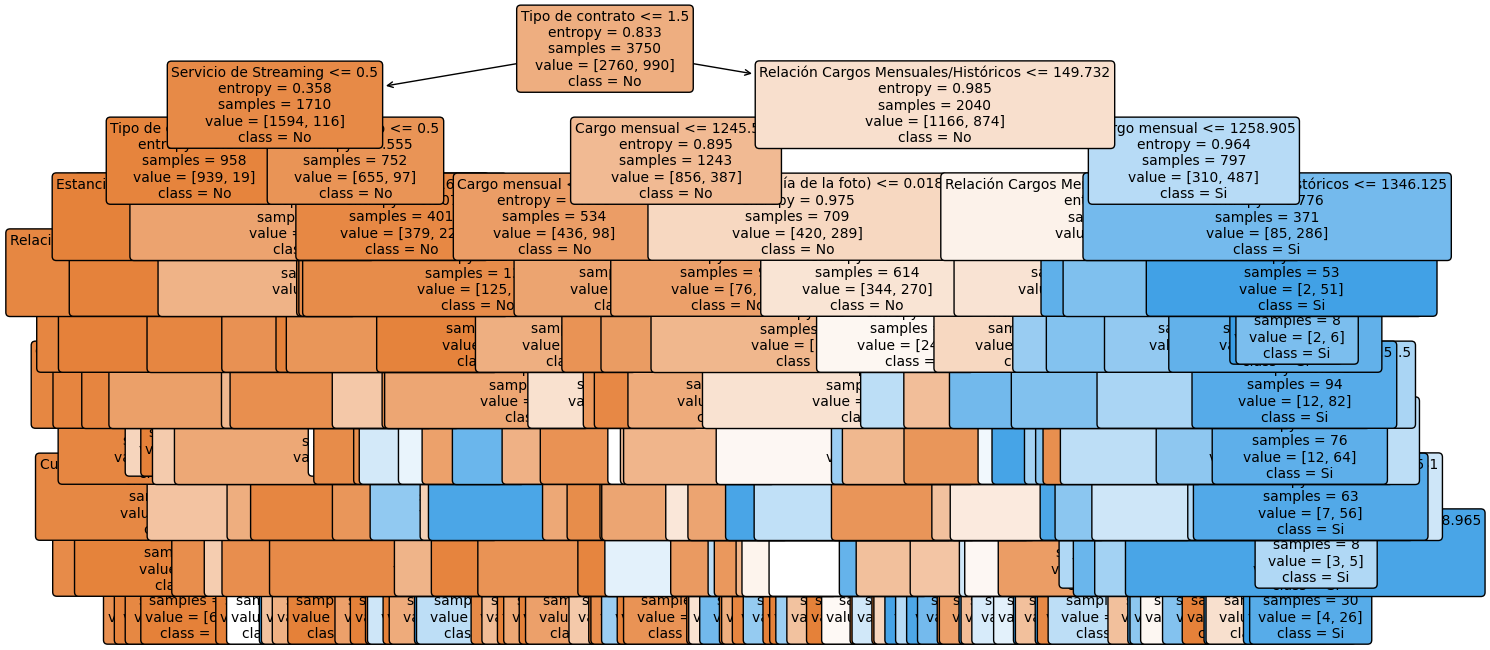

In [295]:
# Visualizar el árbol de decisión
plt.figure(figsize=(15, 8))
plot_tree(best_model, filled=True, feature_names=data.columns[:-1], class_names=["No", "Si"], rounded=True, fontsize=10)
plt.show()

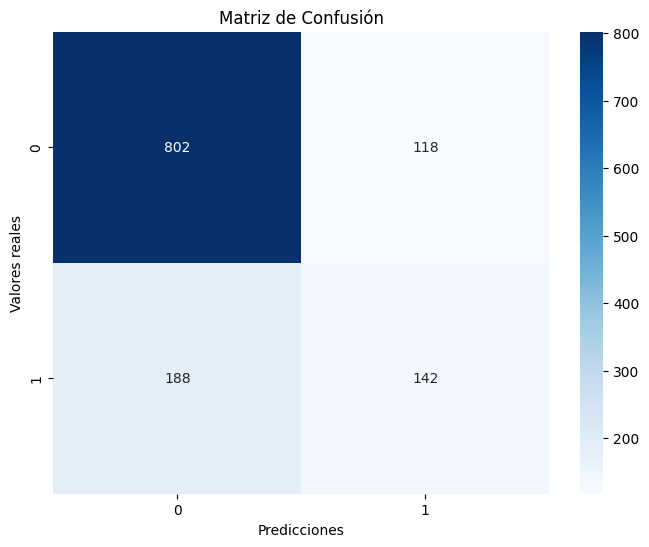

In [296]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()

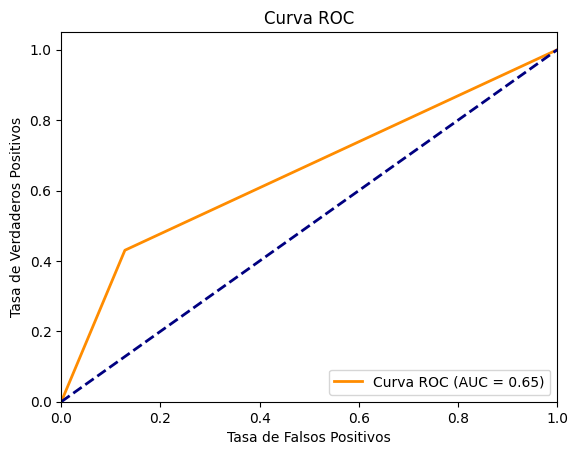

In [297]:
# Ajustar el LabelEncoder a todas las clases posibles en los datos de entrenamiento
label_encoder.fit(Y)

# Etiquetas de prueba
y_test_encoded = label_encoder.transform(y_test)

# Asegurarse de que las predicciones sean valores numéricos (0 y 1)
y_pred_encoded = label_encoder.transform(y_pred)


fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_encoded)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="Curva ROC (AUC = {:.2f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

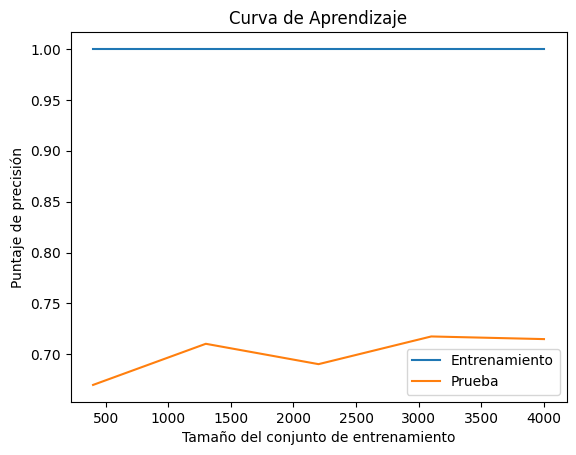

In [298]:
# Ajustar el LabelEncoder a todas las clases posibles en los datos de entrenamiento
label_encoder.fit(Y)

# Codificar las etiquetas de prueba
y_test_encoded = label_encoder.transform(y_test)

# Asegurarse de que las predicciones sean valores numéricos (0 y 1)
y_pred_encoded = label_encoder.transform(y_pred)

train_sizes, train_scores, test_scores = learning_curve(
    model, X, Y, cv=5, n_jobs=-1, scoring="accuracy"
)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Entrenamiento")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Prueba")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Puntaje de precisión")
plt.title("Curva de Aprendizaje")
plt.legend()
plt.show()